### External Validation Test for MHC Class I Prediction

This notebook performs external validation testing based on five pre-trained models for MHC Class I prediction. The goal is to evaluate the performance of the trained models on external data.

#### Requirements
1. **Amino acid interaction preference matrix between HLA allele and immunogenic peptide** : a part of feature generation
2. **Pre-trained Model Weights**: Weights from five fold based trained models.
3. **Feature Indices**: Selected feature indices obtained using RFECV.
4. **External Dataset**: Contains 200 samples also known as independent  or unseen data.
5. **Keras Functional API Models**:  Model  built using Keras Functional API.

### Purpose
To validate the robustness and accuracy of the trained models on unseen external data and analyze their predictive performance.


In [1]:
import os
import sys
os.environ["CUDa_VISIBLE-DEVICES"] = "0" ## Selection of GPU

In [2]:
import pickle
import numpy as np
import gzip
import matplotlib.pyplot as plt
import seaborn as sns
# TensorFlow and Keras Libraries
import keras
import tensorflow as tf
from keras import backend as K
from keras.models import Model
from keras.layers import (
    Input,
    Conv1D,
    MaxPooling1D,
    Flatten,
    Dense,
    Dropout,
    BatchNormalization,
    concatenate
)
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam, RMSprop
from keras.losses import binary_crossentropy, binary_focal_crossentropy
from keras.utils import plot_model
from keras_self_attention import SeqSelfAttention

# Scikit-learn Libraries
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    StratifiedKFold
)
from sklearn.metrics import (
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFECV
from sklearn.svm import SVC
from sklearn.utils.class_weight import compute_class_weight
from sklearn.manifold import TSNE
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from sklearn import metrics

2024-12-31 18:31:31.684448: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-31 18:31:31.701332: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-31 18:31:31.723451: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-31 18:31:31.723480: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-31 18:31:31.738085: I tensorflow/core/platform/cpu_feature_gua

In [3]:
print(f' keras version {keras.__version__}'), 
print(f' tensorflow version {tf.__version__}'),
print(f' python version {sys.version.split()[0]}')

 keras version 3.4.1
 tensorflow version 2.16.2
 python version 3.11.9


In [5]:
'''Load the feature data generated from amino acid interaction matrix of HLA and immunogenic neoepitope from a 
gzipped pickle file, it is mendatory of interaction matrix to test our trained model.
To create this matrix please see another directory and manin manuscript'''

data_path = "/BiO/home/jk/Research_MHC/Feature_generation/Feature_MHC_i_our_independent"  # Update with your directory, and data named
with gzip.open(data_path, "rb") as f:
    array = pickle.load(f)

print(f"Type of first element: {type(array[0])}")
print(f"Shape of feature data: {array[0].shape}")
print(f"Shape of labels: {array[1].shape}")

positive = np.sum(array[1] == 1) # positive class
negative = np.sum(array[1] == 0) # negative
print(f"Number of positive samples: {positive}")
print(f"Number of negative samples: {negative}")

data_ind = array[0]  # Feature data
label_ind = array[1]  # Labels


Type of first element: <class 'numpy.ndarray'>
Shape of feature data: (200, 3321)
Shape of labels: (200,)
Number of positive samples: 98
Number of negative samples: 102


### The selected feature indices file from the trained RFECV must be loaded and then use to encode the external validation data

In [6]:
load_features = np.load("selected_feature_mhc_i.npy") # load the feature index of 1329 
selected_feature_indices = np.where(load_features)[0]
data_selected = data_ind[:, selected_feature_indices] # encoding
data_selected = data_selected.reshape(200, 1329,1) # reshape if necessary
print(f' Shape of external (independent) validation data {data_selected.shape}')

 Shape of external (independent) validation data (200, 1329, 1)


### Model in functional keras API

In [7]:
def model_with_attention1():
    input_shape = (1329, 1)  # one-dimensional
    input_layer = Input(shape=input_shape, name='input_layer')
    # Convolutional layers
    conv1 = Conv1D(27, kernel_size=9, activation='relu', padding='same')(input_layer)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling1D()(conv1)
    conv1 = Dropout(0.7)(pool1)
    conv2 = Conv1D(4, kernel_size=8, activation='relu', padding='same')(conv1)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling1D()(conv2)
    conv2 = Dropout(0.6)(pool2)
    # Attention layer
    att = SeqSelfAttention(attention_type=SeqSelfAttention.ATTENTION_TYPE_MUL,
                           attention_activation='sigmoid', name = "attention")(conv2)
    # Flatten the output for the dense layer
    flatten = Flatten()(att)
    output_layer = Dense(1, activation='sigmoid', name='output_layer')(flatten)
    # Model instantiation
    model = Model(inputs=input_layer, outputs=output_layer)
    learning_rate = 0.001  
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer= optimizer, loss=binary_crossentropy, metrics=['accuracy'])
    model.summary()
    return model

In [8]:
model = model_with_attention1()

2024-12-31 18:33:05.498671: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 638 MB memory:  -> device: 0, name: Quadro RTX 8000, pci bus id: 0000:1b:00.0, compute capability: 7.5
2024-12-31 18:33:05.499617: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 47203 MB memory:  -> device: 1, name: Quadro RTX 8000, pci bus id: 0000:3d:00.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1329, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 1329, 27)       │           270 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1329, 27)       │           108 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 664, 27)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 664, 27)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 664, 4)         │           868 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 664, 4)         │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 332, 4)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 332, 4)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention (SeqSelfAttention)    │ (None, 332, 4)         │            17 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1328)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │         1,329 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,608 (10.19 KB)

 Trainable params: 2,546 (9.95 KB)

 Non-trainable params: 62 (248.00 B)

### ROC curve and Prc curve

In [11]:
def ROC(temp, OutputDir):
    validation_result = temp;
    for x in [validation_result]:

        tprs = []
        aucs = []
        mean_fpr = np.linspace(0, 1, 100)

        i = 0
        for val in x:
            tpr = val['tpr']
            fpr = val['fpr']
            tprs.append(np.interp(mean_fpr, fpr, tpr))
            tprs[-1][0] = 0.0
            roc_auc = auc(fpr, tpr)
            aucs.append(roc_auc)
            plt.plot(fpr, tpr, lw=1, alpha=0.3,label='ROC fold %d (AUC = %0.4f)' % (i+1, roc_auc))

            i += 1

        print;

        plt.plot([0, 1], [0, 1], linestyle='--', lw=1,color='c' , alpha=.8)

        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)
        plt.plot(mean_fpr, mean_tpr, color='b',
                 label=r'Mean ROC (AUC = %0.2f $\pm$ %0.4f)' % (mean_auc, std_auc),
                 lw=1, alpha=.8)

        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                         label=r'$\pm$ 1 std. dev.')
        fpr_tpr_save = {"fpr": mean_fpr, 'tpr' : mean_tpr}
        np.save("our_mhc_i_external_fpr, tpr.npy", fpr_tpr_save)
        plt.xlim([-0.05, 1.05])
        plt.ylim([-0.05, 1.05])
        plt.xlabel('False Positive Rate',fontweight='bold')
        plt.ylabel('True Positive Rate',fontweight='bold')
        plt.legend(loc="lower right")
        plt.title(" External validation (MHC I)", fontweight='bold')
        plt.savefig('roc_External validation_independet MHC I.pdf') #save the figure in your file path
        plt.show()
        plt.close('all')
        
        
         #************************** Precision Recall Curve*********************************
        j=0
        prs = []
        pre_aucs = []
        mean_recal= np.linspace(0, 1, 100)
        for val in x:
            pre = val['prec']
            rec = val['reca']
            prs.append(np.interp(mean_recal, rec, pre))
            prs[-1][0] = 0.0
            p_r_auc = auc(rec, pre)
            pre_aucs.append(p_r_auc)
            plt.plot(rec, pre, lw=1, alpha=0.3,label='PRC fold %d (AUC = %0.3f)' % (j+1, p_r_auc))

            j += 1

        print;

        #plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Random', alpha=.8)

        mean_pre = np.mean(prs, axis=0)
        #mean_pre[-1] = 1.0
        mean_auc = auc(mean_recal, mean_pre)
        std_auc = np.std(pre_aucs)
        plt.plot(mean_recal, mean_pre, color='b',
                 label=r'Mean PRC (AUC = %0.2f $\pm$ %0.4f)' % (mean_auc, std_auc),
                 lw=1, alpha=.8)

        std_pre = np.std(prs, axis=0)
        pre_upper = np.minimum(mean_pre + std_pre, 1)
        pre_lower = np.maximum(mean_pre - std_pre, 0)
        plt.fill_between(mean_recal, pre_lower, pre_upper, color='grey', alpha=.2,
                         label=r'$\pm$ 1 std. dev.')
        

        plt.xlim([0.0, 1.05])
        plt.ylim([-0.05, 1.05])
        plt.xlabel('Recall',fontweight='bold')
        plt.ylabel('Precision',fontweight='bold')
        plt.title('Prc MHC I (External validation)',fontweight='bold')
        plt.legend(loc="lower right")
        plt.show()
        plt.close('all')

        
def cal(X,y, model):
    pred_y =  model.predict(X)
    ROCArea = roc_auc_score(y, pred_y)
    print(ROCArea)
    fpr, tpr, thresholds = roc_curve(y, pred_y)
    lossValue = None
    
    pre, rec, threshlds = precision_recall_curve(y, pred_y)
    pre = np.fliplr([pre])[0]  #so the array is increasing (you won't get negative AUC)
    rec = np.fliplr([rec])[0]  
    AUC_prec_rec = np.trapz(rec,pre)
    AUC_prec_rec = abs(AUC_prec_rec)
    
    
    return { 'fpr' : fpr, 'tpr' : tpr, 'thresholds' : thresholds,'pre_recall_curve':AUC_prec_rec,'prec':pre,'reca':rec}

### load the five model's weights

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
0.9504801920768307
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
0.9484793917567027
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
0.9454781912765107
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
0.9476790716286516
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
0.9463785514205683


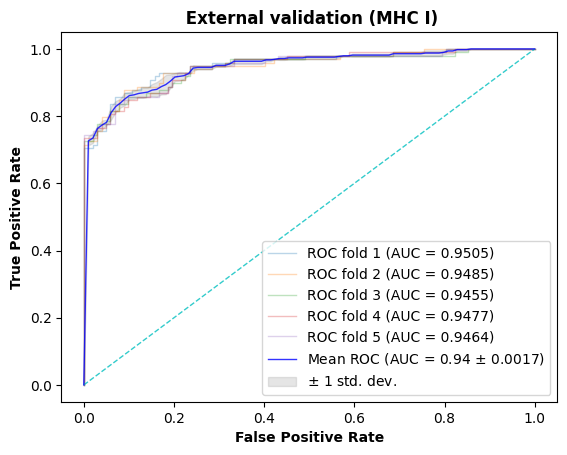

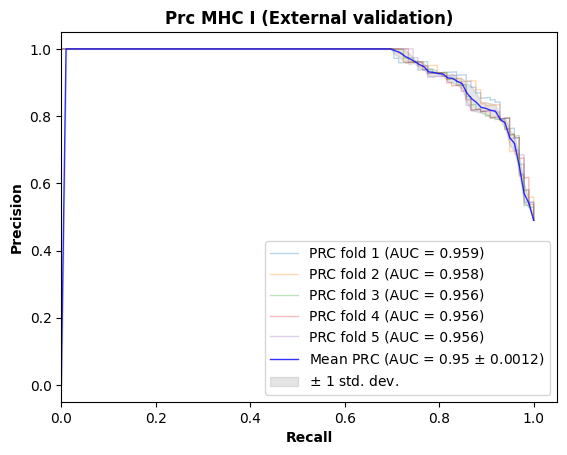

In [12]:
import warnings
warnings.filterwarnings("ignore")
OutputDir=" " # give your own path 
validation_result=[]
for i in range(5):
        model.load_weights(str(i+0)+'Lastepoch_new'+'.h5') # load model weights for five folds
        validation_result.append(cal(data_selected,label_ind, model))
        #validation_result.append(cal(data_papaya,training_label[:,1], model))
temp_dict = (validation_result)
ROC(temp_dict, OutputDir)

### Model Ability to prediction, # model can be used to predict the data directly without label

In [69]:
predictions = model.predict(data_selected)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [70]:
predictions

array([[0.98951954],
       [0.02058558],
       [0.75390416],
       [0.16321956],
       [0.01437442],
       [0.99434066],
       [0.14335427],
       [0.03379054],
       [0.08563833],
       [0.4916102 ],
       [0.06883734],
       [0.99878687],
       [0.4384611 ],
       [0.8187198 ],
       [0.36951917],
       [0.01454923],
       [0.04539985],
       [0.37796193],
       [0.02441083],
       [0.04796683],
       [0.37253967],
       [0.0939498 ],
       [0.00863529],
       [0.82481873],
       [0.7181431 ],
       [0.04892473],
       [0.9848381 ],
       [0.9958377 ],
       [0.0235998 ],
       [0.00739757],
       [0.0725364 ],
       [0.9980781 ],
       [0.9975917 ],
       [0.00766898],
       [0.9995442 ],
       [0.02331348],
       [0.7419681 ],
       [0.03585296],
       [0.999926  ],
       [0.9983734 ],
       [0.02055013],
       [0.18623218],
       [0.9988427 ],
       [0.40682912],
       [0.03025893],
       [0.02092987],
       [0.3254288 ],
       [0.011

In [62]:
predictions_binary = [ 1 if item >=0.5 else 0 for item in predictions]

In [66]:
predictions_binary

[1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0]

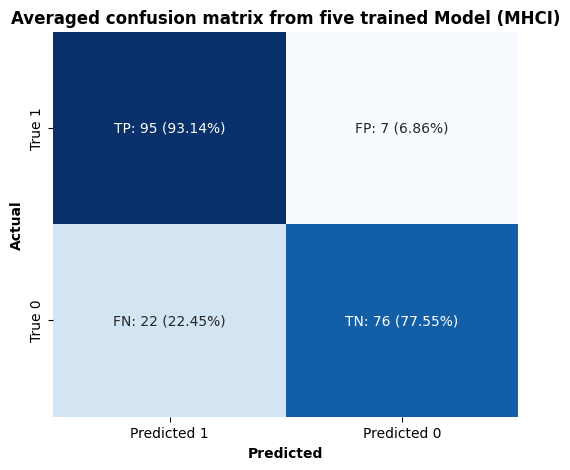

In [91]:
cm = confusion_matrix(label_ind, predictions_binary)
Cm_percentage = Cm / Cm.sum(axis=1, keepdims=True) * 100
Cm_annot = np.array([
    [f"TP: {Cm[0, 0]} ({Cm_percentage[0, 0]:.2f}%)", f"FP: {Cm[0, 1]} ({Cm_percentage[0, 1]:.2f}%)"],
    [f"FN: {Cm[1, 0]} ({Cm_percentage[1, 0]:.2f}%)", f"TN: {Cm[1, 1]} ({Cm_percentage[1, 1]:.2f}%)"]
])
plt.figure(figsize=(6, 5))
sns.heatmap(Cm_percentage, annot=Cm_annot, fmt='', cmap='Blues', cbar=False, xticklabels=['Predicted 1', 'Predicted 0'], yticklabels=['True 1', 'True 0'])
plt.title('Averaged confusion matrix from five trained Model (MHCI)', fontsize=12,fontweight='bold')
plt.ylabel('Actual', fontsize=10,fontweight='bold')
plt.xlabel('Predicted', fontsize=10,fontweight='bold')
plt.show()

In [33]:
666, 104, 73, 693 # confusion matrix

(666, 104, 73, 693)

Derivations

Sensitivity TPR = TP / (TP + FN)

Specificity SPC = TN / (FP + TN)

Precision PPV = TP / (TP + FP)

Negative Predictive Value NPV = TN / (TN + FN)

False Positive Rate FPR = FP / (FP + TN)

False Discovery Rate FDR = FP / (FP + TP)

False Negative Rate FNR = FN / (FN + TP)

Accuracy ACC = (TP + TN) / (P + N)

F1 Score F1 = 2TP / (2TP + FP + FN)

Matthews Correlation Coefficient TP*TN - FP*FN / sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))

/tmp/ipykernel_912237/3663652729.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="Value", y="Measure", data=df, palette="viridis", edgecolor="black")


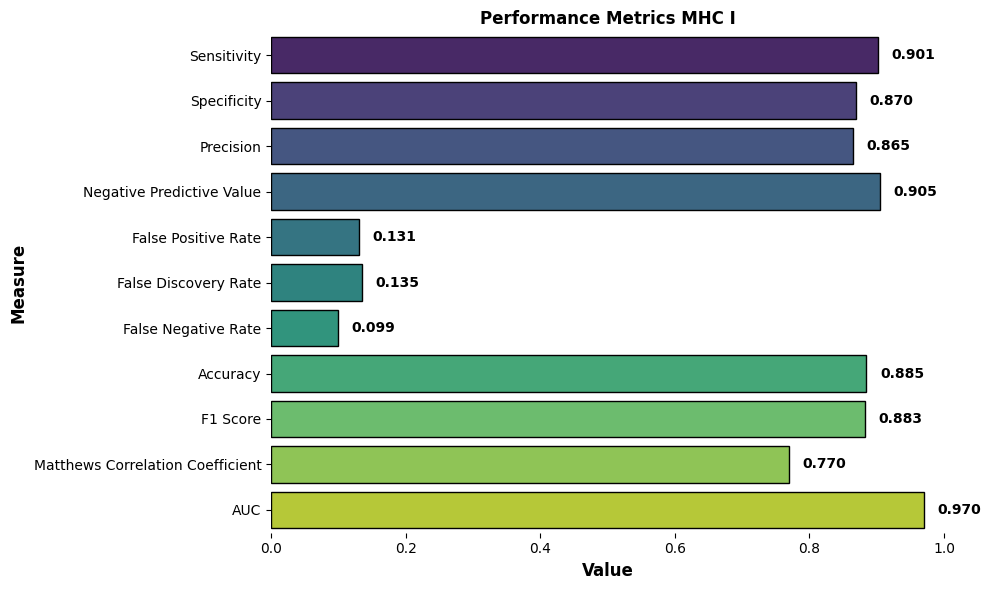

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Data
data = {
    "Measure": [
        "Sensitivity", "Specificity", "Precision", "Negative Predictive Value",
        "False Positive Rate", "False Discovery Rate", "False Negative Rate",
        "Accuracy", "F1 Score", "Matthews Correlation Coefficient", "AUC"
    ],
    "Value": [
        0.9012,
0.8695,
0.8649,
0.9047,
0.1305,
0.1351,
0.0988,
0.8848,
0.8827,
0.7702,0.97
    ]
}

df = pd.DataFrame(data)
plt.figure(figsize=(10, 6))
ax = sns.barplot(x="Value", y="Measure", data=df, palette="viridis", edgecolor="black")
for index, row in df.iterrows():
    ax.text(row["Value"] + 0.02, index, f'{row["Value"]:.3f}', color='black', va='center', fontsize=10, fontweight='bold')
plt.title("Performance Metrics MHC I", fontsize=12, fontweight='bold')
plt.xlabel("Value", fontsize=12,fontweight='bold' )
plt.ylabel("Measure", fontsize=12,fontweight='bold' )
plt.xlim(0, 1)  # Values are between 0 and 1
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
#plt.grid(axis='x', linestyle='--', alpha=0.7)
sns.despine(left=True, bottom=True)

# Show plot
plt.tight_layout()
plt.show()

In [98]:
## Attention weight visualization

In [130]:
 model.load_weights('2Lastepoch_new.h5')

In [131]:
for layers in model.layers:
    print(layers.name)

input_layer
conv1d_12
batch_normalization_12
max_pooling1d_12
dropout_12
conv1d_13
batch_normalization_13
max_pooling1d_13
dropout_13
attention
flatten_6
output_layer


In [93]:
from keras.utils import custom_object_scope
from keras_self_attention import SeqSelfAttention  # or your custom layer import

# Use custom_object_scope to register the custom layer
with custom_object_scope({'SeqSelfAttention': SeqSelfAttention}):
    model = load_model("2Lastepoch_new.h5")

NameError: name 'load_model' is not defined

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step
(200, 332, 4)


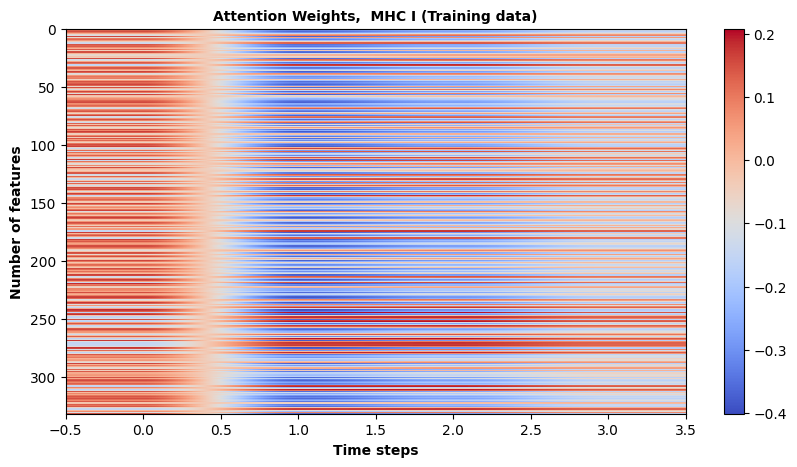

In [127]:
attention_layer = model.get_layer("attention")
attention_model = Model(inputs=model.input, outputs=attention_layer.output)

# Get the attention weights for a sample input
attention_output = attention_model.predict(data_selected)
print(attention_output.shape) 
# Plot the attention as a heatmap if it's 2D
plt.figure(figsize=(10, 5))
plt.imshow(attention_output[0, :, :], cmap='coolwarm', aspect='auto')  # Keep the 2D shape
plt.colorbar()
plt.title("Attention Weights,  MHC I (Training data)", fontsize=10,fontweight='bold')
plt.xlabel("Time steps", fontsize=10,fontweight='bold')
plt.ylabel("Number of features", fontsize=10,fontweight='bold')
plt.savefig("attentin_weight_mhc_i.png")
plt.show()

In [128]:
attention_output

array([[[-0.06013654, -0.01034467,  0.0227626 ,  0.02708235],
        [ 0.14359245, -0.34287772, -0.2583157 , -0.15604834],
        [ 0.15475368, -0.36460662, -0.27693224, -0.1680792 ],
        ...,
        [ 0.15173781, -0.36347243, -0.2759494 , -0.1673327 ],
        [-0.13139835,  0.13810866,  0.14856368,  0.10812782],
        [ 0.14314426, -0.35017028, -0.26452115, -0.15988155]],

       [[-0.30226576,  0.5246216 ,  0.37392542,  0.24502936],
        [ 0.04405489, -0.15212795, -0.16163513, -0.09284977],
        [ 0.02785276, -0.13393837, -0.14735429, -0.08350904],
        ...,
        [-0.11683697,  0.12788588,  0.06019893,  0.04811547],
        [-0.25996292,  0.4454901 ,  0.3130234 ,  0.20652303],
        [ 0.05113424, -0.16001333, -0.16782215, -0.09690004]],

       [[ 0.19984117, -0.23890965, -0.18407595, -0.10951244],
        [ 0.21326782, -0.25336966, -0.19626693, -0.11755455],
        [-0.1914245 ,  0.49006206,  0.442577  ,  0.29325664],
        ...,
        [ 0.20065625, -0.23

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


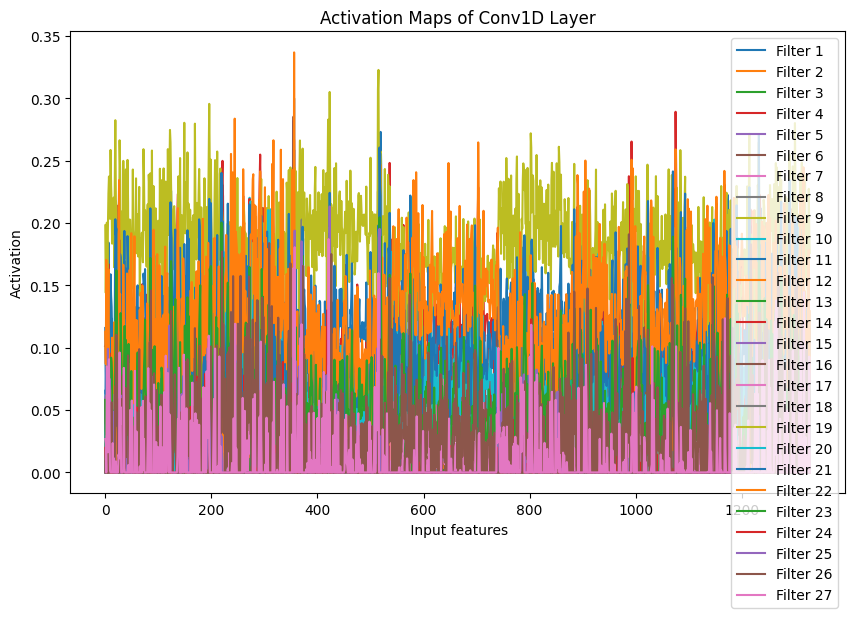

In [136]:
from keras.models import Model
import matplotlib.pyplot as plt
import numpy as np

# Define a new model that outputs the activations from the conv1d_4 layer
layer_name = 'conv1d_12'  # The name of the layer you want to visualize
activation_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)

# Get the activations of a specific input sample
activations = activation_model.predict(data_selected)  # X_input is your input data (a sample or a batch)

# Activations will have shape (batch_size, sequence_length, num_filters)
# You can visualize the activations for one sample in the batch
sample_activations = activations[4]  # If you are visualizing the first sample

# Visualizing the activations
plt.figure(figsize=(10, 6))
for i in range(sample_activations.shape[1]):  # Iterate through each filter in the conv1d layer
    plt.plot(sample_activations[:, i], label=f"Filter {i+1}")
plt.title("Activation Maps of Conv1D Layer")
plt.xlabel(" Input features")
plt.ylabel("Activation")
plt.legend()
plt.show()

### Optuna hyperparameter tunning

In [47]:
import optuna
from optuna.integration import TFKerasPruningCallback

In [48]:
def model_with_attention(trial):
    input_shape = (1329, 1)  # one-dimensional
    input_layer = Input(shape=input_shape, name='input_layer')

    # Convolutional layers with hyperparameters to be tuned
    conv1_filters = trial.suggest_int('conv1_filters', 4, 32)
    conv1_kernel_size = trial.suggest_int('conv1_kernel_size', 3, 9)
    conv1 = Conv1D(conv1_filters, kernel_size=conv1_kernel_size, activation='relu', padding='same')(input_layer)
    pool1 = MaxPooling1D()(conv1)
    conv1 = Dropout(0.5)(pool1)

    conv2_filters = trial.suggest_int('conv2_filters', 4, 32)
    conv2_kernel_size = trial.suggest_int('conv2_kernel_size', 3, 9)
    conv2 = Conv1D(conv2_filters, kernel_size=conv2_kernel_size, activation='relu', padding='same')(conv1)
    pool2 = MaxPooling1D()(conv2)
    conv2 = Dropout(0.5)(pool2)

    # Attention layer
    att = SeqSelfAttention(attention_type=SeqSelfAttention.ATTENTION_TYPE_MUL,
                           attention_activation='sigmoid')(conv2)

    # Flatten the output for the dense layer
    flatten = Flatten()(att)
    output_layer = Dense(1, activation='sigmoid', name='output_layer')(flatten)
    model = Model(inputs=input_layer, outputs=output_layer)

    # Hyperparameters for the optimizer
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=binary_crossentropy, metrics=['accuracy'])
    return model


In [49]:
def objective(trial):
    model = model_with_attention(trial)

    X_train, X_test, y_train, y_test = train_test_split(optimal_data_scaled, labels, test_size=0.2, random_state=42)

    # Fit the model
    model.fit(X_train, y_train,
              validation_data=(X_test, y_test),
              epochs=10,  # Set to a lower number for quicker trials
              callbacks=[TFKerasPruningCallback(trial, 'val_loss')],
              verbose=0)  # Suppress training output for cleaner output

    # Evaluate the model
    score = model.evaluate(X_test, y_test, verbose=0)
    return score[1]  # Return accuracy as the objective

# Create the study and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print('Best trial:')
trial = study.best_trial

print(f'Accuracy: {trial.value}')
print('Best hyperparameters: ')
for key, value in trial.params.items():
    print(f'{key}: {value}')

[I 2024-07-12 12:34:13,704] A new study created in memory with name: no-name-cd05f811-3dac-4e00-adb3-c6b176fb46ec
/tmp/ipykernel_617441/1794377335.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
[I 2024-07-12 12:34:33,819] Trial 0 finished with value: 0.5188801884651184 and parameters: {'conv1_filters': 7, 'conv1_kernel_size': 6, 'conv2_filters': 22, 'conv2_kernel_size': 9, 'learning_rate': 2.1363982131901717e-05}. Best is trial 0 with value: 0.5188801884651184.
[I 2024-07-12 12:34:54,017] Trial 1 finished with value: 0.7044270634651184 and parameters: {'conv1_filters': 17, 'conv1_kernel_size': 7, 'conv2_filters': 21, 'conv2_kernel_size': 9, 'learning_rate': 0.00042171640379525205}. Best is trial 1 with value: 0.7044270634651184.
[I 2024-07-12 12:35:13,4

Best trial:
Accuracy: 0.87890625
Best hyperparameters: 
conv1_filters: 27
conv1_kernel_size: 9
conv2_filters: 4
conv2_kernel_size: 8
learning_rate: 0.003953248318992427


In [44]:
#insilico mutagenis analysis

In [80]:
print(model.input_shape)


(None, 1329, 1)


In [81]:
with open("../mhc_i_ind_200_seq.txt", "r") as f:
    data_pure = f.readlines()

In [84]:
input_ref_seq = data_selected[2] # use pure data with A C D....... given above
np.shape(input_ref_seq)

(1329,)

In [71]:
nts= ['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y']

mutation = np.zeros((len((data_pure)),10,20)) # x_train is your original sequence (In ACGT Form)

for k, seq in enumerate((data_pure)):
    orig = seq
    #input_ref_seq = onehot2(seq)  # seq is your onehot encoded form of sequence
    input_ref_seq = data_selected
    input_ref_seq = np.expand_dims(input_ref_seq,axis=0)
    pred_y =  model.predict(input_ref_seq)
    #ref_pred=np.argmax(pred_y,axis=1
   # ref_pred = mode1.predict(input_ref_seq)[0][0]
    
    
    
    for i in range(9):
        for j, nt in enumerate(nts):
            txt = list(orig)
            txt[i]=nt
            #print(alt_seq)
            
            #alt_seq[i]= nt
            alt_seq = ''.join(txt)
            
            input_alt_seq = onehot2(alt_seq)
            input_alt_seq = np.expand_dims(input_alt_seq,axis=0)
            alt_pred= model.predict(input_alt_seq)
            diff = abs(pred_y[0][1] - alt_pred[0][1])  # you may try the absolute differences
            mutation[k,i,j] = diff
            alt_seq=''

ValueError: as_list() is not defined on an unknown TensorShape.